In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Anisotropic NFW profile

In [2]:
# load a test halo catalog
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar',
                            redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')

In [3]:
from halotools.mock_observables import tpcf

rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [6]:
coords = np.vstack((halocat.halo_table['halo_x'],
                         halocat.halo_table['halo_y'],
                         halocat.halo_table['halo_z'])).T

mask = halocat.halo_table['halo_mpeak']>10**12

In [7]:
result_0 = tpcf(coords[mask], rbins=rbins, period=halocat.Lbox, num_threads=4)

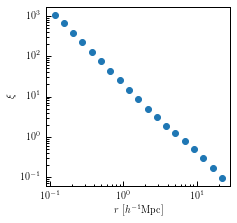

In [8]:
fig = plt.figure(figsize=(3.3,3.3))
l1, = plt.plot(rbin_centers, result_0, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.ylabel(r'$\xi$')
plt.show()

## NFW profile

In [79]:
from halotools.empirical_models import HodModelFactory
from intrinsic_alignments.ia_models.anisotropic_nfw_phase_space import AnisotropicNFWPhaseSpace
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace

from halotools.empirical_models import Zheng07Cens, Zheng07Sats

In [83]:
cens_occ_model =  MyCentralOccupation(threshold=-20)
#cens_occ_model =  Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  SubhaloCountSatelliteOccupation(threshold=-20, subhalo_table=halocat.halo_table)
#sats_occ_model =  Zheng07Sats()
sats_prof_model = AnisotropicNFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile')
                                )

In [84]:
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

TypeError: 'numpy.float64' object cannot be interpreted as an index

In [ ]:
from halotools.empirical_models import OccupationComponent
from halotools.utils import crossmatch

class SubhaloCountSatelliteOccupation(OccupationComponent):

    def __init__(self, threshold, subhalo_table, prim_haloprop_key=model_defaults.prim_haloprop_key, mask_value=10**12):
        """
        """
        upper_occupation_bound = float("inf")
        OccupationComponent.__init__(self,
                    gal_type = 'satellites',
                    threshold = threshold,
                    prim_haloprop_key=prim_haloprop_key,
                    upper_occupation_bound = upper_occupation_bound)
            
        self.mask_key = mask_key
        self.subhalo_table = subhalo_table
        self.param_dict = ({'satellite_mask_value': mask_value})

    def mean_occupation(self, **kwargs):
        """
        """   
        table = kwargs['table']
        subhalo_table = self.subhalo_table
            
        # apply mask
        mask = (subhalo_table[self.mask_key] >= self.param_dict['satellite_mask_value'])
        subhalo_table = subhalo_table[mask]
                
        # count the number of subhaloes in each halo
        host_ids, Nsubs = np.unique(self.subhalo_table['halo_hostid'], return_counts=True) 
            
        inds1, inds2 = crossmatch(table['halo_id'], host_ids)
        Nsat = np.zeros(len(table))
        Nsat[inds1] = Nsubs[inds2] 
            
        return Nsat

    def mc_occupation(self, **kwargs):
        """
        """
        table = kwargs['table']
        meanocc = self.mean_occupation(**kwargs)
        result = meanocc
        table['halo_num_satellites'] = result.astype('int')
        
        return result

from halotools.empirical_models import OccupationComponent

class MyCentralOccupation(OccupationComponent):
    """
    """
    def __init__(self, threshold, prim_haloprop_key=model_defaults.prim_haloprop_key, mask_value=10**12):
        """
        """

        OccupationComponent.__init__(self,
            gal_type = 'centrals',
            threshold = threshold,
            prim_haloprop_key=prim_haloprop_key,
            upper_occupation_bound = 1)
        
        self.mask_key = mask_key
        self.param_dict = ({'central_mask_value': mask_value})

    def mean_occupation(self, **kwargs):
        """
        """
        table = kwargs['table']
        return np.zeros(len(table)) + 1
    
    def mc_occupation(self, **kwargs):
        """
        """
        table = kwargs['table']
        meanocc = self.mean_occupation(**kwargs)
        result = meanocc
        table['halo_num_centrals'] = result.astype('int')
        
        return result

